In [ ]:
# TAREA 6 - Pronóstico

In [1]:
'''
Librerias a utilizar
'''
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

In [4]:
df = pd.read_csv('/content/movies.csv')
df

,Unnamed: 0,id,title,overview,release_date,popularity,vote_average,vote_count
0,0,278,The Shawshank Redemption,Imprisoned in the 1940s for the double murder ...,9/23/1994,26.9579,8.712,28675
1,1,238,The Godfather,"Spanning the years 1945 to 1955, a chronicle o...",3/14/1972,26.5804,8.686,21701
2,2,240,The Godfather Part II,In the continuing saga of the Corleone crime f...,12/20/1974,15.6559,8.571,13099
3,3,424,Schindler's List,The true story of how businessman Oskar Schind...,12/15/1993,12.5642,8.565,16616
4,4,389,12 Angry Men,The defense and the prosecution have rested an...,4/10/1957,14.6028,8.549,9307
...,...,...,...,...,...,...,...,...
8555,8555,238603,Earth to Echo,After a construction project begins digging in...,6/14/2014,1.6137,5.900,593
8556,8556,11968,Into the Blue,When they take some friends on an extreme spor...,9/30/2005,3.3432,5.902,1539
8557,8557,439079,The Nun,A priest with a haunted past and a novice on t...,9/5/2018,15.1733,5.901,6862
8558,8558,513409,Earthquake Bird,"Tokyo, Japan, 1989. Lucy Fly, a foreigner who ...",11/1/2019,1.1859,5.900,448


In [ ]:
'''
Retomando lo hecho en la anterior tarea 5
Aplicar al menos un algoritmo no supervisado a tus datos para encontrar estructuras subyacentes
'''

Buscando la mejor combinación de parámetros...

eps=0.2, min_samples=3, clusters=66, DBI=0.88
eps=0.2, min_samples=5, clusters=25, DBI=0.919
eps=0.2, min_samples=10, clusters=9, DBI=0.763
eps=0.5, min_samples=3, clusters=14, DBI=0.89
eps=0.5, min_samples=5, clusters=4, DBI=0.558
eps=0.5, min_samples=10, clusters=2, DBI=0.362
eps=0.8, min_samples=3, clusters=3, DBI=0.539
eps=0.8, min_samples=5, clusters=2, DBI=0.395
eps=1.0, min_samples=3, clusters=3, DBI=0.604
eps=1.0, min_samples=5, clusters=2, DBI=0.614
eps=1.5, min_samples=3, clusters=3, DBI=0.482

--- Mejor configuración encontrada ---
eps = 0.5, min_samples = 10, DBI = 0.362

Conteo de películas por cluster:
cluster
 0    8203
-1     347
 1      10
Name: count, dtype: int64


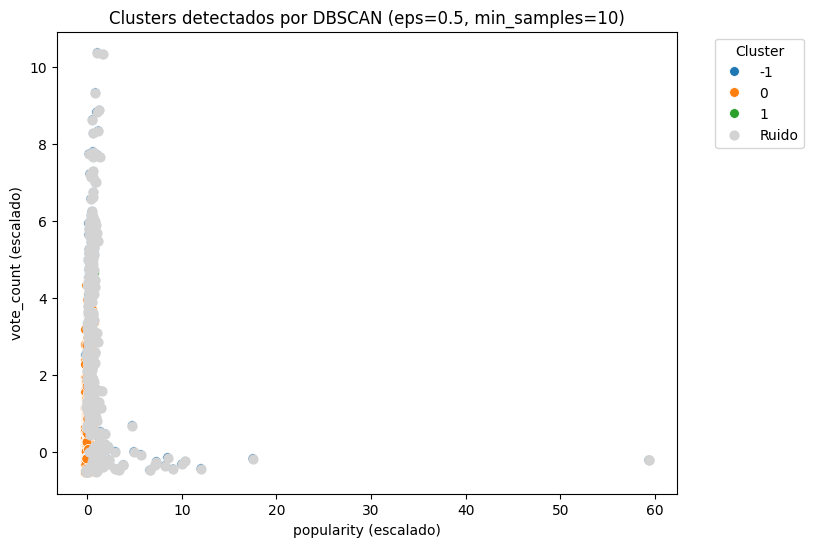

In [5]:
# Seleccionar solamente las columnas numéricas relevantes para nuestra investigación
X = df.select_dtypes(include=[np.number]).dropna()
X_scaled = StandardScaler().fit_transform(X)

# Búsqueda de parámetros: combinaciones de eps y min_samples
mejor_eps, mejor_min, mejor_dbi = None, None, np.inf
mejor_labels = None

print("Buscando la mejor combinación de parámetros...\n")

for eps in [0.2, 0.5, 0.8, 1.0, 1.5, 2.0]:
    for min_samples in [3, 5, 10]:
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(X_scaled)
        labels = db.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        # Calcular DBI solo si hay al menos 2 clusters
        if n_clusters > 1:
            mask = labels != -1
            dbi = davies_bouldin_score(X_scaled[mask], labels[mask])

            print(f"eps={eps}, min_samples={min_samples}, clusters={n_clusters}, DBI={round(dbi,3)}")

            # Guardar la mejor configuración (menor DBI)
            if dbi < mejor_dbi:
                mejor_dbi = dbi
                mejor_eps = eps
                mejor_min = min_samples
                mejor_labels = labels

print("\n--- Mejor configuración encontrada ---")
print(f"eps = {mejor_eps}, min_samples = {mejor_min}, DBI = {round(mejor_dbi,3)}")

# Asignar los clusters al DataFrame
df["cluster"] = mejor_labels

# Conteo de películas por cluster
print("\nConteo de películas por cluster:")
print(df["cluster"].value_counts())

# --- Visualización de los clusters obtenidos ---
plt.figure(figsize=(8,6))

# Convertimos X_scaled a DataFrame para graficar con etiquetas
X_plot = pd.DataFrame(X_scaled, columns=X.columns)
X_plot["cluster"] = df["cluster"]

# Determinar qué variables usar para graficar
if "popularity" in X.columns and "vote_count" in X.columns:
    xvar, yvar = "popularity", "vote_count"
else:
    xvar, yvar = X.columns[:2]

# Graficar los clusters
sns.scatterplot(
    data=X_plot,
    x=xvar,
    y=yvar,
    hue="cluster",
    palette="tab10",
    s=50
)

# Resaltar puntos de ruido
plt.scatter(
    X_plot.loc[X_plot["cluster"] == -1, xvar],
    X_plot.loc[X_plot["cluster"] == -1, yvar],
    c="lightgray", label="Ruido", s=40
)

plt.title(f"Clusters detectados por DBSCAN (eps={mejor_eps}, min_samples={mejor_min})")
plt.xlabel(f"{xvar} (escalado)")
plt.ylabel(f"{yvar} (escalado)")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


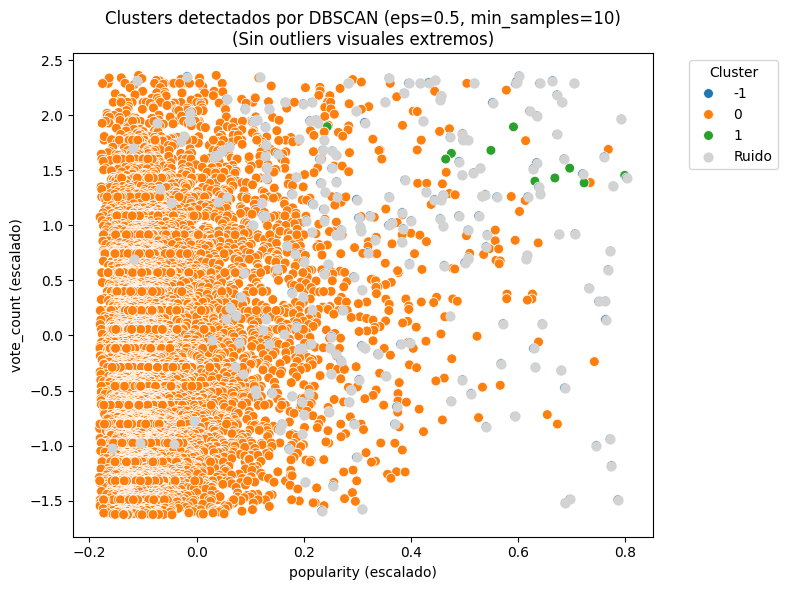

Nota: Los valores atípicos extremos fueron removidos únicamente para la visualización, no del análisis.


In [8]:
# --- Visualización mejorada de los clusters obtenidos ---

plt.figure(figsize=(8,6))

# Convertimos X_scaled a DataFrame para graficar con etiquetas
X_plot = pd.DataFrame(X_scaled, columns=X.columns)
X_plot["cluster"] = df["cluster"]

# Determinar qué variables usar para graficar
if "popularity" in X.columns and "vote_count" in X.columns:
    xvar, yvar = "popularity", "vote_count"
else:
    xvar, yvar = X.columns[:2]

# --- Detección y filtrado de outliers extremos para mejor visualización ---
# Usamos percentiles para definir un rango de valores "razonables"
p1_x, p99_x = np.percentile(X_plot[xvar], [1, 99])
p1_y, p99_y = np.percentile(X_plot[yvar], [1, 99])

# Filtramos los datos que están dentro de ese rango
X_vis = X_plot[
    (X_plot[xvar] >= p1_x) & (X_plot[xvar] <= p99_x) &
    (X_plot[yvar] >= p1_y) & (X_plot[yvar] <= p99_y)
]

# --- Graficar los clusters sin outliers visuales ---
sns.scatterplot(
    data=X_vis,
    x=xvar,
    y=yvar,
    hue="cluster",
    palette="tab10",
    s=50
)

# Resaltar puntos de ruido
plt.scatter(
    X_vis.loc[X_vis["cluster"] == -1, xvar],
    X_vis.loc[X_vis["cluster"] == -1, yvar],
    c="lightgray", label="Ruido", s=40
)

plt.title(f"Clusters detectados por DBSCAN (eps={mejor_eps}, min_samples={mejor_min})\n(Sin outliers visuales extremos)")
plt.xlabel(f"{xvar} (escalado)")
plt.ylabel(f"{yvar} (escalado)")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Nota aclaratoria:
print("Nota: Los valores atípicos extremos fueron removidos únicamente para la visualización, no del análisis.")


In [7]:
'''
continuando con lo solicitado en la tarea 6, ahora se aplica lo siguiente
Aplicar al menos un algoritmo supervisado a tus datos para predecir alguna variable (puede ser interpolación o extrapolación)

En este caso partiré de un Random Forest Regressor (ensamble) y una regresión lineal

Para esto se toma nuevamente como variable objetivo "vote_average" y como variables predictoras
"popularity", "vote_count" y el resto de variables numéricas

Tamién como métricas se usarán MAE, MSE, RMSE, MAPE y R².
Haciendo por último una evaluaión entrenamiento/prueba que resulta de la división 80/20.
'''

'\ncontinuando con lo solicitado en la tarea 6, ahora se aplica lo siguiente\nAplicar al menos un algoritmo supervisado a tus datos para predecir alguna variable (puede ser interpolación o extrapolación)\n\nEn este caso partiré de un Random Forest Regressor (ensamble) y una regresión lineal\n\nPara esto se toma nuevamente como variable objetivo "vote_average" \n'

Variable objetivo (target): vote_average
Variables predictoras: ['Unnamed: 0', 'id', 'popularity', 'vote_count', 'cluster']

--- Regresión Lineal ---
MAE: 0.0598
MSE: 0.0085
RMSE: 0.0924
MAPE: 0.83%
R²: 0.9754

--- Random Forest ---
MAE: 0.0088
MSE: 0.0002
RMSE: 0.0132
MAPE: 0.13%
R²: 0.9995


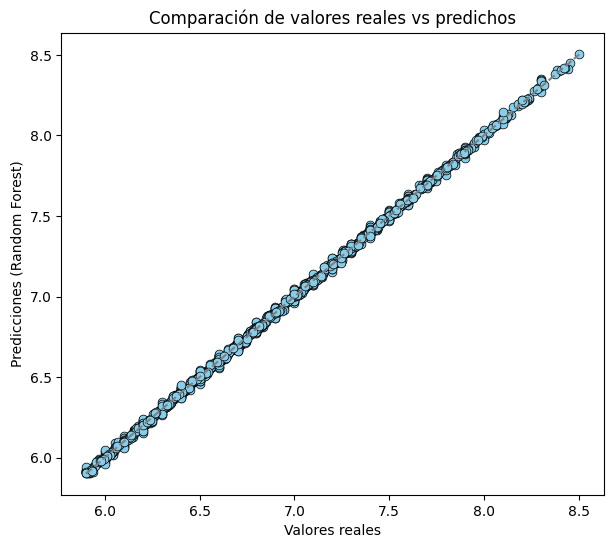

In [6]:
'''
Selección de variable objetivo (target) y variables predictoras (features)
'''
# Solo las columnas numéricas
X = df.select_dtypes(include=[np.number]).dropna().copy()

# Elegimos una variable a predecir (retomando vote_average)
if "vote_average" in X.columns:
    y = X["vote_average"]
    X = X.drop(columns=["vote_average"])
else:
    y = X.iloc[:, -1]
    X = X.iloc[:, :-1]

print("Variable objetivo (target):", y.name)
print("Variables predictoras:", list(X.columns))

'''
División de datos en entrenamiento y prueba
'''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

'''
Estandarizando...
'''
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

'''
Y los modelos a aplicar son:
1. Regresión Lineal
2. Random Forest Regressor
'''

# ---- RREGRESIÓN LINEAL ----
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

# ---- RANDOM FOREST ----
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

'''
Funciones de métricas
'''
def metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, mape, r2

'''
Evaluación de modelos
'''
mae_lr, mse_lr, rmse_lr, mape_lr, r2_lr = metrics(y_test, y_pred_lr)
mae_rf, mse_rf, rmse_rf, mape_rf, r2_rf = metrics(y_test, y_pred_rf)

print("\n--- Regresión Lineal ---")
print(f"MAE: {mae_lr:.4f}")
print(f"MSE: {mse_lr:.4f}")
print(f"RMSE: {rmse_lr:.4f}")
print(f"MAPE: {mape_lr*100:.2f}%")
print(f"R²: {r2_lr:.4f}")

print("\n--- Random Forest ---")
print(f"MAE: {mae_rf:.4f}")
print(f"MSE: {mse_rf:.4f}")
print(f"RMSE: {rmse_rf:.4f}")
print(f"MAPE: {mape_rf*100:.2f}%")
print(f"R²: {r2_rf:.4f}")

'''
Gráfica final de la comparación de los valores reales vs predichos
'''
plt.figure(figsize=(7,6))
sns.scatterplot(x=y_test, y=y_pred_rf, color="skyblue", s=40, edgecolor="k")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "--", color="gray")
plt.xlabel("Valores reales")
plt.ylabel("Predicciones (Random Forest)")
plt.title("Comparación de valores reales vs predichos")
plt.show()
